# Preparación para el TF MDS

## Modelación

Dataset: https://www.yelp.com/dataset/documentation/main

**Requiere ejecución prévia del notebook 01_preparación_de_los_datos** para recortar las fotos al formato PNG con 224 x 224 y organizarlas en carpetas.

Se utiliza la versión [vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) del transformer **Transformer ViT**, ya pré-entrenado con 14 millones de imagenes en 21.843 clases.

In [21]:
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

### Tuneo del modelo pré-entrenado con nuestro toy dataset de imagenes y clases

In [3]:
!run_image_classification.py --train_dir dataset/toy --output_dir ./outputs/ --remove_unused_columns False --do_train --do_eval

### Predicir imagen nueva

In [23]:
# Buscar una imagen (recortada) que no esté en el dataset usado para tunear

df5 = pickle.load(open('checkpoints/df5.pkl','rb'))

dataset_path = 'dataset/toy/'
full_dataset_path = 'dataset/photos' #fotos  no recortadas

for img in range(len(df5)):
    if not os.path.exists(dataset_path + df5.iloc[img].label + '/' + df5.iloc[img].photo_id + '.png'):
        new_image_path = full_dataset_path + '/' + df5.iloc[img].photo_id + '.jpg'
        print('{} no existe en el toy dataset'.format(new_image_path))
        break 

dataset/photos/--0h6FMC0V8aMtKQylojEg.jpg no existe en el toy dataset


In [24]:
# predicción con el modelo pre-entrenado (pero no tuneado)

#url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(new_image_path)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# outputs\checkpoint-500

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: tobacco shop, tobacconist shop, tobacconist


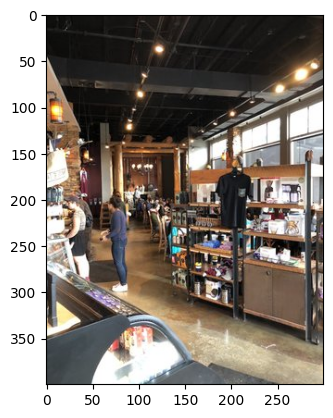

In [26]:
plt.imshow(image);
#ax[0].set_title('Original');

In [27]:
# predicción con el modelo tuneado

#url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(new_image_path)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('outputs\checkpoint-500')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: inside


Referencias:
- [Tutorial DeiT](https://pytorch.org/tutorials/beginner/vt_tutorial.html)
- [Tutorial distributed PyTorch](https://theaisummer.com/distributed-training-pytorch/) / [GIT](https://github.com/The-AI-Summer/pytorch-ddp/blob/main/train_ddp_mixed_presicion.py)
- [Tutorial tuneo transformers](https://huggingface.co/docs/transformers/main/en/training#finetune-with-trainer)
- `pip install git+https://github.com/huggingface/transformers` (4.22.0.dev0)
- `pip install datasets`
- `pip install evaluate`
- [PyPi Transformers](https://pypi.org/project/transformers/)
- [Modelo DeiT](https://huggingface.co/facebook/deit-small-distilled-patch16-224) y su [documentación](https://huggingface.co/docs/transformers/main/en/model_doc/deit#overview)   